In [1]:
import preprocessing.preprocessing as pp
import torch
from models import nodeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualization import mesh_viewer
import evaluation.evaluation as ev
import graph_matching.graph_matching as gm
import graph_matching.graph_connection as gc

In [2]:

nodesFileNerve =  "~/Documents/Intestine/nerve-mask/nodes_nerve_bs2_fh.csv"
edgesFileNerve = "~/Documents/Intestine/nerve-mask/edges_nerve_bs2_fh.csv"

nodesFileLymph =  "~/Documents/Intestine/lymph-mask/nodes_lymph_bs2_fh.csv"
edgesFileLymph = "~/Documents/Intestine/lymph-mask/edges_lymph_bs2_fh.csv"

nodes_n = pd.read_csv(nodesFileNerve, sep = ";", index_col= "id")
edges_n = pd.read_csv(edgesFileNerve, sep = ";", index_col= "id")
nodes_l = pd.read_csv(nodesFileLymph, sep = ";", index_col= "id")
edges_l = pd.read_csv(edgesFileLymph, sep = ";", index_col= "id")


# scaling with the factors provided by luciano
nodes_l = pp.scalePosition(nodes_l, (1.625,1.625,6))
nodes_n = pp.scalePosition(nodes_n, (1.625,1.625,6))


# Node Classification using a contracted graph by spatial proximity to differentiate 3 node types (nerve, lymph, connected)

In [3]:
#rename the nodes to have unqiue identifiers for different types
# giving nodes from different files unique names
edges_n, nodes_n = pp.relable_edges_nodes(edges_n, nodes_n, "n")
edges_l, nodes_l = pp.relable_edges_nodes(edges_l, nodes_l, "l")


### Contracted Node creation pipeline

In [4]:
from scipy.sparse.csgraph import connected_components

# create an adjacency matrix for nodes from two node sets that are closer than a given distance
adjMcsr = pp.distance_based_adjacency(nodes_n, nodes_l, th = 0.03)

# find the connected components in the adjacency matrix (nodes that will be merged)
num, labels = connected_components(csgraph=adjMcsr, directed = False)

#create a dict where each new node contains all the nodes that will be merged into it
con_comp = pp.connected_components_dict(labels)

#take only the connected components that contain > 1 element, otherwise no merge is necessary 
rel_comp = pp.relevant_connected_components(con_comp, nodes_n.shape[0], ("n","l")) # how should it be possible that there is a connected component with less 2 nodes? - adds diagonal to matrix

G_contract = gc.graphContraction(nodes_l, nodes_n, edges_l, edges_n, rel_comp)
G_contract_einf = pp.convertToEinfach(G_contract, self_loops = False, isolates = False)
pp.enrichNodeAttributes(G_contract_einf)

Graph from combined extraction with contraction.


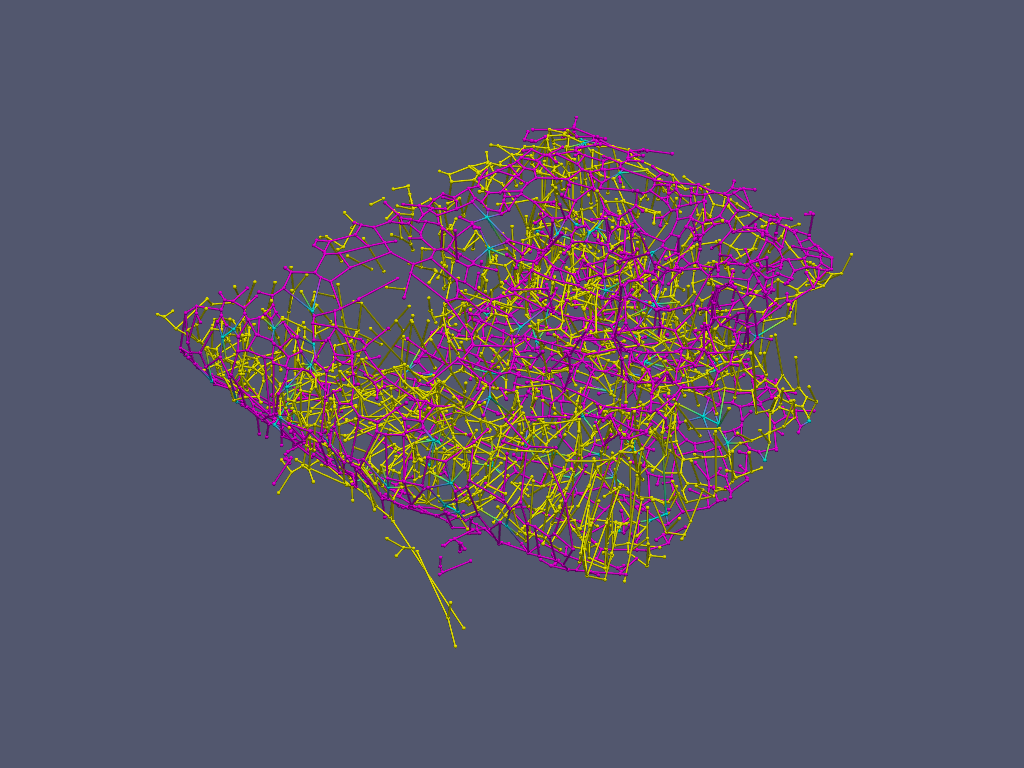

In [5]:
print("Graph from combined extraction with contraction.")
mesh_viewer.renderNXGraph(G_contract_einf, vtk = 0, backend = "static")

### Link addition pipeline - alternatively to creating new contracted nodes (imo better), just link nodes that are very close. 

In [6]:
dist_mat_sparse = pp.network_sparse_distance_matrix(nodes_l, nodes_n, 0.05)

G_link = gc.graphLinking(nodes_l, nodes_n, edges_l, edges_n, dist_mat_sparse)
G_link_einf = pp.convertToEinfach(G_link, self_loops = False, isolates = False)


Graph from combined extraction with additional links.


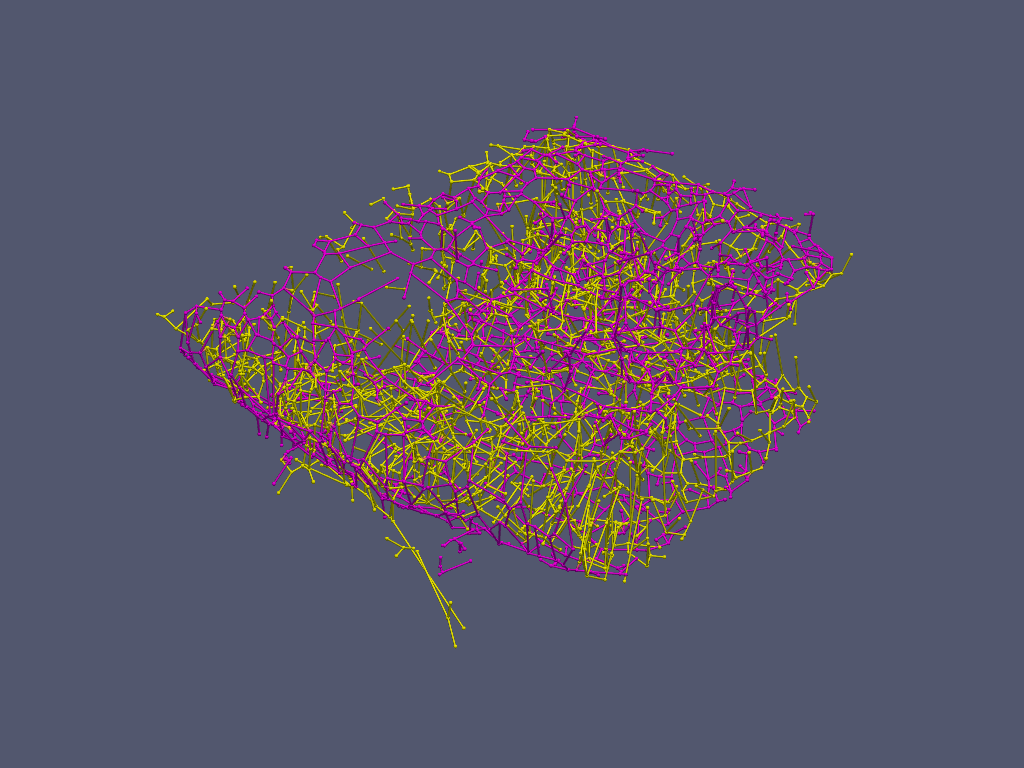

In [7]:
print("Graph from combined extraction with additional links.")
mesh_viewer.renderNXGraph(G_link_einf, vtk = 0, backend = "static")

## Start the classification pipeline

In [8]:
# create the ground truth for the node class

# defines the graph to work with
all_nodes = list(G_contract_einf.nodes)

nerve_class = np.array([elem[-1] == "n" for elem in all_nodes])*0
lymph_class = np.array([elem[-1] == "l" for elem in all_nodes])*1
combined_class = np.array([elem[-1] == "c" for elem in all_nodes])*2
class_assign = nerve_class+lymph_class+combined_class


# create the training and testing masks
train_mask = np.random.choice(np.arange(0, len(class_assign)), size= int(len(class_assign)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(class_assign)), train_mask)

# convert to torch tensor objects
train_mask= torch.tensor(train_mask)
test_mask= torch.tensor(test_mask)

np.random.seed(1234567)
unique, counts = np.unique(class_assign[train_mask], return_counts=True)
print("Train-Mask Class Distribution: ")
print(unique)
print(counts)

print("Test-Mask Class Distribution: ")
unique, counts = np.unique(class_assign[test_mask], return_counts=True)
print(unique)
print(counts)


# convert the graph to a networkx graph

from torch_geometric.utils.convert import from_networkx
NX_G_contract_einf = from_networkx(G_contract_einf)
NX_G_contract_einf.y = torch.tensor(class_assign)


Train-Mask Class Distribution: 
[0 1 2]
[1427 1653   55]
Test-Mask Class Distribution: 
[0 1 2]
[349 418  17]


In [9]:
num_feat = NX_G_contract_einf.x.shape[1]
num_class = len(np.unique(NX_G_contract_einf.y))
netGCN = nodeClassifier.GCN_VS
netSAGE = nodeClassifier.SAGE_VS

modelGCN = nodeClassifier.nodeClassifier(netGCN, hidden_channels=32, features = np.arange(num_feat),classes = num_class, num_layers= 6, lr = 0.002)
modelSAGE = nodeClassifier.nodeClassifier(netSAGE, hidden_channels=32, features = np.arange(num_feat),classes = num_class, num_layers= 6, lr = 0.002)

models = [modelGCN, modelSAGE]


epochs = 20
loss_l = np.zeros((epochs, len(models)))
acc_l = np.zeros((epochs, len(models)))
for epoch in range(1, epochs +1):
      for i, model in enumerate(models):
            loss = model.train(NX_G_contract_einf, train_mask)
            loss_l[epoch-1, i] = loss.detach().numpy().copy()
            #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            test_acc = model.test(NX_G_contract_einf, test_mask)
            acc_l[epoch-1, i] = test_acc



for model in models:
      test_acc = model.test(NX_G_contract_einf, test_mask)
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
      print(f'Test Accuracy: {test_acc:.4f}')


Epoch: 020, Loss: 0.7923
Test Accuracy: 0.5140
Epoch: 020, Loss: 0.7923
Test Accuracy: 0.5332


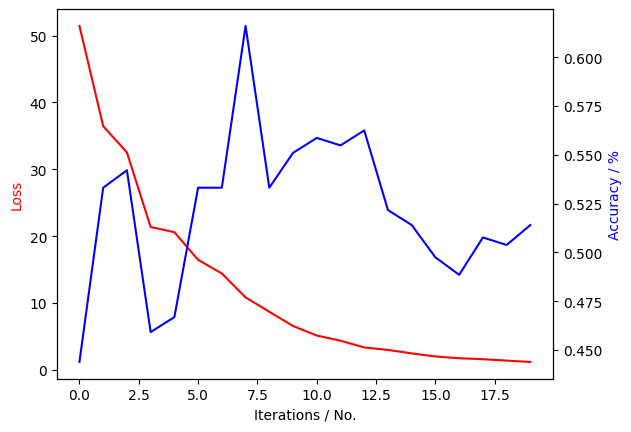

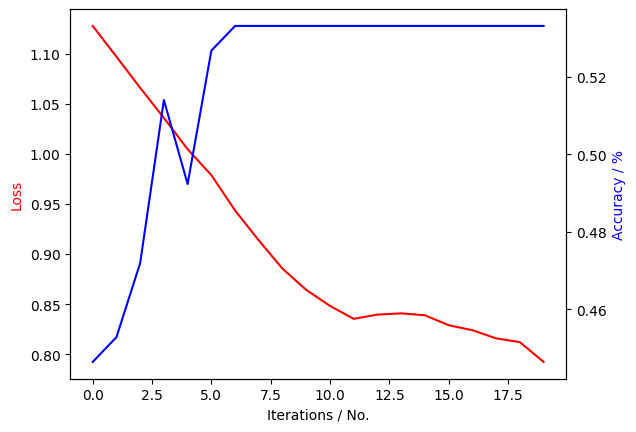

In [10]:
for i in range(len(models)):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loss_l[:,i], color = "red")
    ax2.plot(acc_l[:,i], color = "blue")

    ax1.set_xlabel('Iterations / No.')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Accuracy / %', color='b')



# Try node classification for the dual graph.

In [11]:
#graph to turn dual
L_link_einf = pp.makeDual(G_link_einf)
class_label_list, node_lab, node_lab_explain =  pp.getLablesForDual(L_link_einf)

networkDualXG = from_networkx(L_link_einf)
networkDualXG.y = torch.tensor(np.array(class_label_list))



for key,val in node_lab.items():
    print("Class Label: " + str(node_lab[key]))
    print("Edge Type: " + str(node_lab_explain[val]))


Class Label: 0
Edge Type: ('l', 'l')
Class Label: 1
Edge Type: ('n', 'n')
Class Label: 2
Edge Type: ('l', 'n')


/home/laurin/.local/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  data[key] = torch.tensor(value)


In [12]:
# create the training and testing masks
train_mask_dual = np.random.choice(np.arange(0, len(class_label_list)), size= int(len(class_label_list)*0.8), replace = False)
test_mask_dual = np.delete(np.arange(0, len(class_label_list)), train_mask_dual)

# convert to torch tensor objects
train_mask_dual= torch.tensor(train_mask_dual)
test_mask_dual= torch.tensor(test_mask_dual)


num_feat_dual = networkDualXG.x.shape[1]
num_class_dual = len(np.unique(networkDualXG.y))


In [13]:
optimizer = torch.optim.Adam
criterion = torch.nn.CrossEntropyLoss

modelGCN = nodeClassifier.nodeClassifier(netGCN, hidden_channels=32, features = np.arange(num_feat_dual),classes = num_class_dual, num_layers= 6)
modelSAGE = nodeClassifier.nodeClassifier(netSAGE, hidden_channels=32, features = np.arange(num_feat_dual),classes = num_class_dual, num_layers= 6)


models = [modelGCN, modelSAGE]


epochs = 20
loss_l = np.zeros((epochs, len(models)))
acc_l = np.zeros((epochs, len(models)))
for epoch in range(1, epochs +1):
      for i, model in enumerate(models):
            loss = model.train(networkDualXG, train_mask_dual)
            loss_l[epoch-1, i] = loss.detach().numpy().copy()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            test_acc = model.test(networkDualXG, test_mask_dual)
            acc_l[epoch-1, i] = test_acc

for model in models:
      test_acc = model.test(networkDualXG, test_mask_dual)
      print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 17025.0801
Epoch: 001, Loss: 1.1875
Epoch: 002, Loss: 7362.5244
Epoch: 002, Loss: 1.0763
Epoch: 003, Loss: 7036.3691
Epoch: 003, Loss: 1.0404
Epoch: 004, Loss: 7470.7271
Epoch: 004, Loss: 0.9923
Epoch: 005, Loss: 5114.6431
Epoch: 005, Loss: 0.9503
Epoch: 006, Loss: 4033.9258
Epoch: 006, Loss: 0.9546
Epoch: 007, Loss: 3267.9353
Epoch: 007, Loss: 0.9638
Epoch: 008, Loss: 2482.2051
Epoch: 008, Loss: 0.9573
Epoch: 009, Loss: 2409.2070
Epoch: 009, Loss: 0.9429
Epoch: 010, Loss: 1690.4604
Epoch: 010, Loss: 0.9315
Epoch: 011, Loss: 1470.7242
Epoch: 011, Loss: 0.9342
Epoch: 012, Loss: 1101.5006
Epoch: 012, Loss: 0.9365
Epoch: 013, Loss: 956.6888
Epoch: 013, Loss: 0.9341
Epoch: 014, Loss: 742.9036
Epoch: 014, Loss: 0.9370
Epoch: 015, Loss: 567.9202
Epoch: 015, Loss: 0.9356
Epoch: 016, Loss: 422.1448
Epoch: 016, Loss: 0.9307
Epoch: 017, Loss: 324.9798
Epoch: 017, Loss: 0.9227
Epoch: 018, Loss: 237.9535
Epoch: 018, Loss: 0.9218
Epoch: 019, Loss: 230.0852
Epoch: 019, Loss: 0.9235

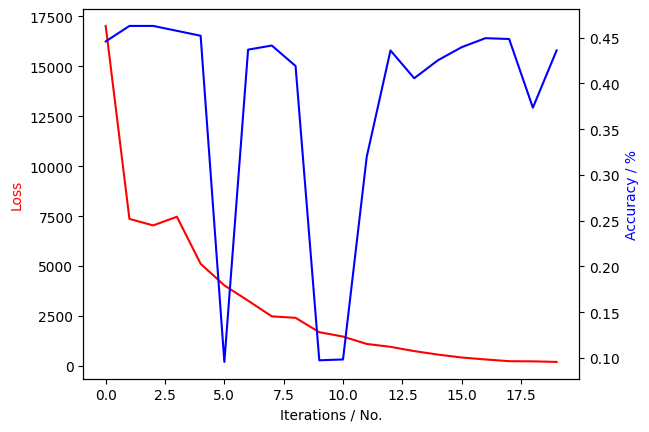

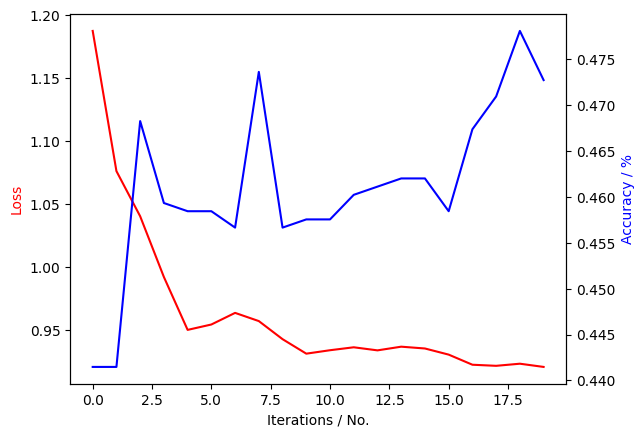

In [14]:
ev.plot_loss_acc(loss_l, acc_l)

# Use wadb to perform parameter for hyperparameter search 

In [15]:
bestMod = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_dual), classes = num_class_dual,num_layers= 6,  lr = 0.0002548, weight_decay= 0.000192) # 0.0001548 with super high iterations 


epochs = 10
loss_l = np.zeros((epochs, 1))
acc_l = np.zeros((epochs, 1))
for epoch in range(1, epochs +1):
      loss = bestMod.train(networkDualXG, train_mask_dual)
      loss_l[epoch-1] = loss.detach().numpy().copy()
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
      test_acc = bestMod.test(networkDualXG, test_mask_dual)
      acc_l[epoch-1] = test_acc


test_acc = bestMod.test(networkDualXG, test_mask_dual)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.1689
Epoch: 002, Loss: 1.1175
Epoch: 003, Loss: 1.0947
Epoch: 004, Loss: 1.0635
Epoch: 005, Loss: 1.0345
Epoch: 006, Loss: 1.0259
Epoch: 007, Loss: 1.0115
Epoch: 008, Loss: 0.9977
Epoch: 009, Loss: 0.9938
Epoch: 010, Loss: 0.9903
Test Accuracy: 0.4584


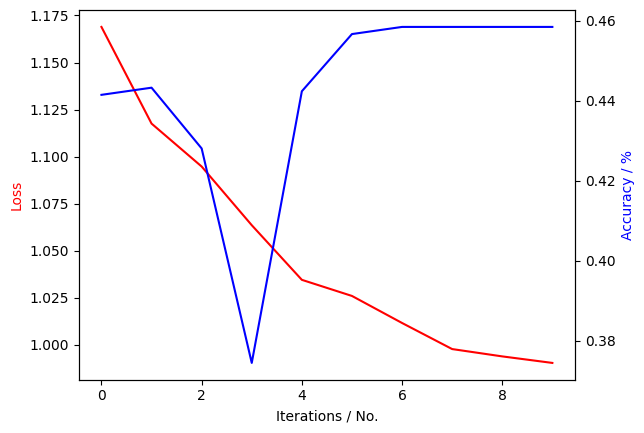

In [16]:
ev.plot_loss_acc(loss_l, acc_l)

Validation set Accuracy: 0.4770248524941892
ROC AUC: 0.5179430422787931
Dual graph from separate extraction with additional links. 
{-9563740248991129212: 0, 16533286298510895140: 1, 3484773024759882964: 2}
-9563740248991129212
0
16533286298510895140
1
3484773024759882964
2


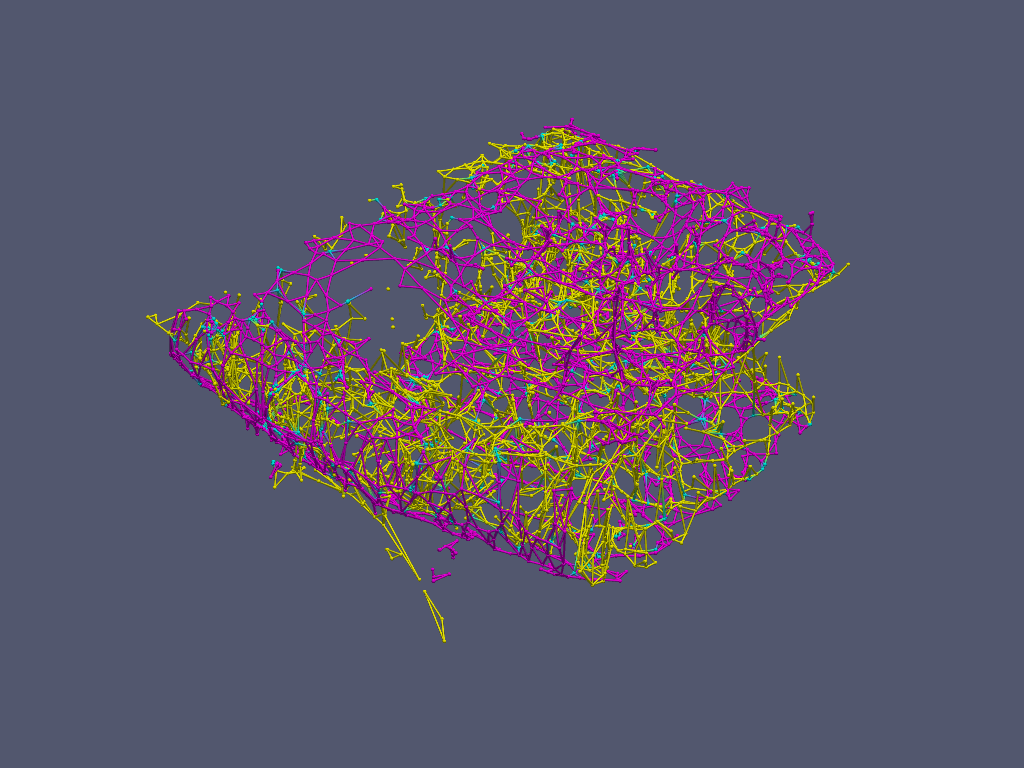

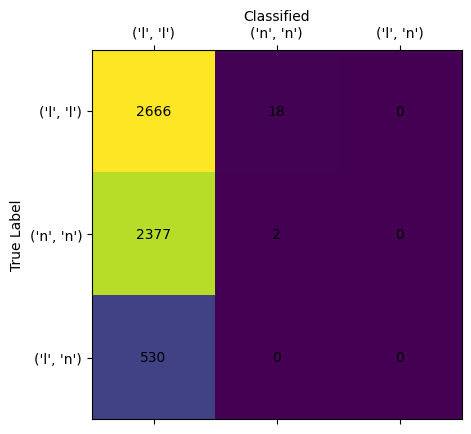

In [17]:
full_mask_dual = torch.tensor(np.arange(0, networkDualXG.y.shape[0]))
pred_whole = bestMod.predictions(networkDualXG)
pred_whole_acc = bestMod.test(networkDualXG, full_mask_dual)

lab_list = []
for k,v in node_lab_explain.items():
    lab_list.append(v)


print("Validation set Accuracy: " + str(pred_whole_acc))
ev.plot_confusion_matrix(np.array(networkDualXG.y), pred_whole, lab_list)
rocL = ev.eval_roc_auc(networkDualXG.y, bestMod.predictions(networkDualXG, max_prob= False))
print("ROC AUC: " + str(rocL))


print("Dual graph from separate extraction with additional links. ")
mesh_viewer.renderNXGraph(L_link_einf, dual = True, vtk = 0, backend = "static")